In [1]:
import numpy as np
import pandas as pd
import os
import gc
import re
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob # parse the files name
from pathlib import Path
import warnings
import imgaug as ia
from imgaug import augmenters as iaa
warnings.filterwarnings("ignore")
#pal = sns.color_palette()

HOME = os.environ['HOME']
data_folder = Path(os.path.join(HOME, 'ninja_project/data/human_protein_atlas'))

In [2]:
train_data = pd.read_csv(str(data_folder / 'train.csv'))
train_image_path = data_folder / 'train'
test_image_path = data_folder / 'test'
train_images_list = os.listdir(str(train_image_path))
test_images_list = os.listdir(str(test_image_path))

In [3]:
green_png = glob(str(train_image_path / '*_green.png'))
blue_png = glob(str(train_image_path / '*_blue.png'))
red_png = glob(str(train_image_path / '*_red.png'))
yellow_png = glob(str(train_image_path / '*_yellow.png'))

# Label list

In [4]:
labels_dict = {
0:  "Nucleoplasm", 
1:  "Nuclear membrane",   
2:  "Nucleoli",   
3:  "Nucleoli fibrillar center" ,  
4:  "Nuclear speckles"   ,
5:  "Nuclear bodies"   ,
6:  "Endoplasmic reticulum",   
7:  "Golgi apparatus"   ,
8:  "Peroxisomes"   ,
9:  "Endosomes"   ,
10:  "Lysosomes"   ,
11:  "Intermediate filaments",   
12:  "Actin filaments"   ,
13:  "Focal adhesion sites",   
14:  "Microtubules"   ,
15:  "Microtubule ends",   
16:  "Cytokinetic bridge",   
17:  "Mitotic spindle"   ,
18:  "Microtubule organizing center" ,  
19:  "Centrosome"   ,
20:  "Lipid droplets",   
21:  "Plasma membrane",   
22:  "Cell junctions"  , 
23:  "Mitochondria"   ,
24:  "Aggresome"   ,
25:  "Cytosol",
26:  "Cytoplasmic bodies",   
27:  "Rods & rings" 
}

# Training data 

In [5]:
train_data.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [6]:
from collections import Counter, defaultdict

labels = train_data['Target'].apply(lambda x: x.split(' '))

count_labels = defaultdict(int)
for line in labels:
    for l in line:
        count_labels[l] += 1
            
mapping_labels = dict()
for k in count_labels.keys():
    mapping_labels[labels_dict[int(k)]] = count_labels[k]


In [7]:
labels_df = pd.DataFrame.from_dict(mapping_labels, orient='index', columns=['count'])
labels_df.reset_index(inplace=True)
labels_df.rename(columns={'index': 'protein'}, inplace=True)

In [8]:
def get_labels(row):
    labels = row.split(' ')
    labels = [int(x) for x in labels]
    return labels
    
train_data['labels'] = train_data['Target'].apply(get_labels)
train_data['nb_labels'] = train_data['labels'].apply(lambda x:len(x))

In [9]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer(classes=np.array(list(labels_dict.keys())))
mulit_label_encoder = mlb.fit_transform(train_data['labels'])
mulit_label_df = pd.DataFrame(mulit_label_encoder, columns=list(labels_dict.values()))
train_data = pd.concat([train_data, mulit_label_df], axis=1)


In [10]:
color_mapping = {
    'green': 'the protein of interest',
    'blue': 'nucleus',
    'red': 'microtubules',
    'yellow': 'endoplasmic reticulum'
}

# Building a baseline model

In [11]:
print('The test set size turns out to be {:.2f}% compared to the train set'.format(
    np.round(len(test_images_list) / len(train_images_list) * 100)))
      
    

The test set size turns out to be 38.00% compared to the train set


### Training-testing split and K-Fold Cross-Validation

As our test data is 38 % of size compared to the train set it makes sense to use 3-Fold cross validation where the test set is 33 % of size compared to the train set. As we are working with neural networks that can be demanding in computational resources, let's only use 2 repetitions.

In [12]:
from sklearn.model_selection import RepeatedKFold, train_test_split
train_ids, valid_ids = train_test_split(train_data.Id.values, 
                                        test_size=0.3, 
                                        stratify=train_data['nb_labels'])



In [13]:
splitter = RepeatedKFold(n_splits=3, n_repeats=1, random_state=0)
partitions = []
for train_idx, test_idx in splitter.split(train_data.index.values):
    partition = {}
    partition['training'] = train_data.Id.values[train_idx]    
    partition['validation'] = train_data.Id.values[test_idx]
    partitions.append(partition)


In [14]:
partitions[0]

{'training': array(['000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0',
        '000a9596-bbc4-11e8-b2bc-ac1f6b6435d0',
        '000c99ba-bba4-11e8-b2b9-ac1f6b6435d0', ...,
        'ffe55eba-bbba-11e8-b2ba-ac1f6b6435d0',
        'ffe61798-bbc3-11e8-b2bc-ac1f6b6435d0',
        'ffe8cf0c-bba9-11e8-b2ba-ac1f6b6435d0'], dtype=object),
 'validation': array(['00070df0-bbc3-11e8-b2bc-ac1f6b6435d0',
        '001838f8-bbca-11e8-b2bc-ac1f6b6435d0',
        '0020af02-bbba-11e8-b2ba-ac1f6b6435d0', ...,
        'fff189d8-bbab-11e8-b2ba-ac1f6b6435d0',
        'fffdf7e0-bbc4-11e8-b2bc-ac1f6b6435d0',
        'fffe0ffe-bbc0-11e8-b2bb-ac1f6b6435d0'], dtype=object)}

In [15]:
partition = partitions[0]

print("Number of samples in train: {}".format(len(partition["training"])))
print("Number of samples in validation: {}".format(len(partition["validation"])))

Number of samples in train: 20714
Number of samples in validation: 10358


## Setting Parameters

In [16]:
class ModelParameters:
    def __init__(self, trainpath, testpath, n_classes=28, image_rows=512, image_cols=512, batch_size=32, 
                 n_channels=3, row_scale_factor=1, col_scale_factor=1, n_epochs=1):
        self.basepath = trainpath
        self.testpath = testpath
        self.n_classes = n_classes
        self.image_rows = image_rows
        self.image_cols = image_cols
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.row_scale_factor = row_scale_factor
        self.col_scale_factor = col_scale_factor
        self.scaled_row_dim = np.int(self.image_rows / self.row_scale_factor)
        self.scaled_col_dim = np.int(self.image_cols / self.col_scale_factor)
        self.n_epochs = n_epochs
        
model_parameters = ModelParameters(train_image_path, test_image_path)        

## Target Labels Group Iterator

In [17]:
reverse_train_labels = dict((v,k) for k,v in labels_dict.items())
class TargetLabelsGroupIterator:
    def __init__(self, target_labels, batch_size, basepath):
        self.target_labels = target_labels
        self.target_list = [reverse_train_labels[key] for key in target_labels]
        self.batch_shape = (batch_size, 4, 512, 512)
        self.basepath = basepath
    
    def find_matching_data_entries(self):
        train_data['check_cols'] = train_data.labels.apply(lambda l: self.check_subset(l))
        self.images_identifier = train_data[train_data.check_cols == 1].Id.values
        train_data.drop('check_cols', axis=1, inplace=True)
        
    def check_subset(self, target):
        return np.where(set(target).issubset(set(self.target_list)), 1, 0)
    
    def load_image(self, image_id):
        images = np.zeros(shape=(self.batch_shape[1], self.batch_shape[2], self.batch_shape[3]))
        images[0, :, :] = cv2.imread(str(self.basepath / '{}_green.png'.format(image_id)), 0)
        images[1, :, :] = cv2.imread(str(self.basepath / '{}_red.png'.format(image_id)), 0)
        images[2, :, :] = cv2.imread(str(self.basepath / '{}_blue.png'.format(image_id)), 0)
        images[3, :, :] = cv2.imread(str(self.basepath / '{}_yellow.png'.format(image_id)), 0)
        return images

    def get_loader(self):
        filenames = []
        idx = 0
        images_array = np.zeros(self.batch_shape)
        for image_id in self.images_identifier:
            images_array[idx, :, :, :] = self.load_image(image_id)
            filenames.append(image_id)
            idx += 1
            if idx == self.batch_shape[0]:
                yield filenames, images_array
                filenames = []
                images_array = np.zeros(self.batch_shape)
                idx = 0
        if idx > 0:
            yield filenames, images_array
            

In [18]:
def make_image_row(image, subax, title):
    subax[0].imshow(image[0], cmap="Greens")
    subax[1].imshow(image[1], cmap="Reds")
    subax[1].set_title("stained microtubules")
    subax[2].imshow(image[2], cmap="Blues")
    subax[2].set_title("stained nucleus")
    subax[3].imshow(image[3], cmap="Oranges")
    subax[3].set_title("stained endoplasmatic reticulum")
    subax[0].set_title(title)
    return subax

def make_title(file_id):
    file_targets = train_data.loc[train_data.Id == file_id, "labels"].values[0]
    title = " - "
    for n in file_targets:
        title += labels_dict[n] + " - "
    return title

In [19]:
target_names = ["Lysosomes", "Endosomes"]
batch_size = 3
imageloader = TargetLabelsGroupIterator(target_names, batch_size, train_image_path)
imageloader.find_matching_data_entries()
iterator = imageloader.get_loader()


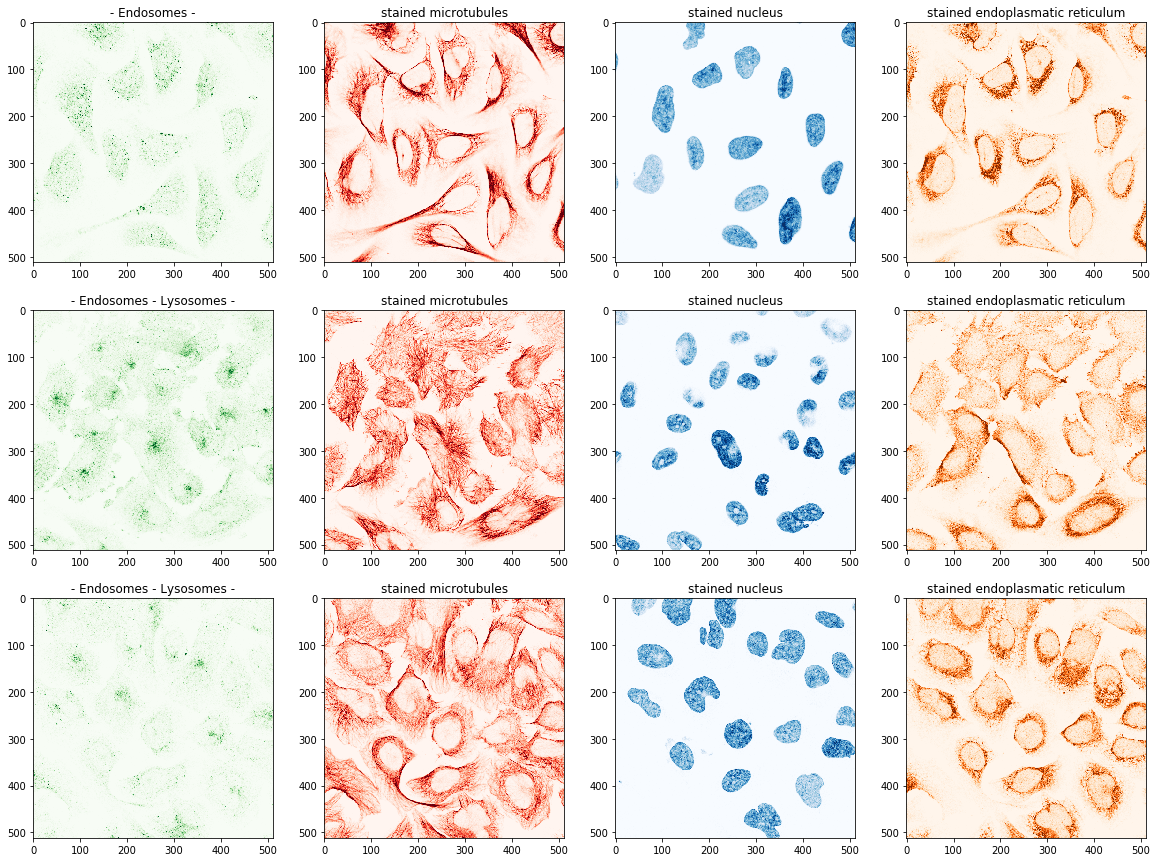

In [20]:
file_ids, images = next(iterator)

fig, ax = plt.subplots(len(file_ids), 4, figsize=(20, 5*len(file_ids)))
if ax.shape == (4,):
    ax = ax.reshape(1,-1)
    
for n in range(len(file_ids)):
    make_image_row(images[n], ax[n], make_title(file_ids[n]))

## Image preprocessor

In [21]:
from skimage.transform import resize 

class ImagePreprocessor:
    def __init__(self, model_parameter, use_aug=False, is_training=True):
        self.parameter = model_parameter
        self.basepath = self.parameter.basepath
        self.scaled_row_dim = self.parameter.scaled_row_dim
        self.scaled_col_dim = self.parameter.scaled_col_dim
        self.n_channels = self.parameter.n_channels
        self.use_aug = use_aug
        self.is_training = is_training
    
    def preprocess(self, image):
        image = self.img_resize(image)
        #image = self.img_reshape(image)
        image = self.img_normalize(image)
        if (self.use_aug or self.is_training) == True:
            image = self.img_augmentation(image)
        return image
        
    def img_resize(self, image):
        image = resize(image, (self.scaled_row_dim, self.scaled_col_dim))
        return image

    def img_reshape(self, image):
        image = np.reshape(image, (image.shape[0], image.shape[1], self.n_channels))
        return image
    
    def img_normalize(self, image):
        image = np.divide(image, 255)
        return image
    
    def img_augmentation(self, image):
        augment_img = iaa.Sequential([
            iaa.OneOf([
                iaa.Crop(percent=(0, 0.1)), # random crops
                iaa.Affine(rotate=0),
                iaa.Affine(rotate=90),
                iaa.Affine(rotate=180),
                iaa.Affine(rotate=270),
                iaa.Fliplr(0.5), # horizontal flips
                iaa.Flipud(0.5),
                # Small gaussian blur with random sigma between 0 and 0.5.
                # But we only blur about 50% of all images.
                iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0, 0.5))),
                # Strengthen or weaken the contrast in each image.
                iaa.ContrastNormalization((0.75, 1.5)),
                # Add gaussian noise.
                # For 50% of all images, we sample the noise once per pixel.
                # For the other 50% of all images, we sample the noise per pixel AND
                # channel. This can change the color (not only brightness) of the
                # pixels.
                iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
                # Make some images brighter and some darker.
                # In 20% of all cases, we sample the multiplier once per channel,
                # which can end up changing the color of the images.
                iaa.Multiply((0.8, 1.2), per_channel=0.2)
                # Apply affine transformations to each image.
                # Scale/zoom them, translate/move them, rotate them and shear them.
            ])], random_order=True)
        image_aug = augment_img.augment_image(image)
        return image_aug
        
    def load_image(self, image_id):
        #images = np.zeros(shape=(512, 512, 4))        
        #images[:, :, 0] = cv2.imread(str(self.basepath / '{}_green.png'.format(image_id)), 0)
        #images[:, :, 1] = cv2.imread(str(self.basepath / '{}_red.png'.format(image_id)), 0)
        #images[:, :, 2] = cv2.imread(str(self.basepath / '{}_blue.png'.format(image_id)), 0)
        #images[:, :, 3] = cv2.imread(str(self.basepath / '{}_yellow.png'.format(image_id)), 0)  
        #return image[:,:,0:self.parameter.n_channels]
        G = cv2.imread(str(self.basepath / '{}_green.png'.format(image_id)), 0)
        R = cv2.imread(str(self.basepath / '{}_red.png'.format(image_id)), 0)
        B = cv2.imread(str(self.basepath / '{}_blue.png'.format(image_id)), 0)
        Y = cv2.imread(str(self.basepath / '{}_yellow.png'.format(image_id)), 0)          
        im = np.stack((
            R/2 + Y/2, 
            G/2 + Y/2, 
            B), -1)
        return im
    
image_preprocessor = ImagePreprocessor(model_parameters, use_aug=True, is_training=True)

(512, 512)
(512, 512)


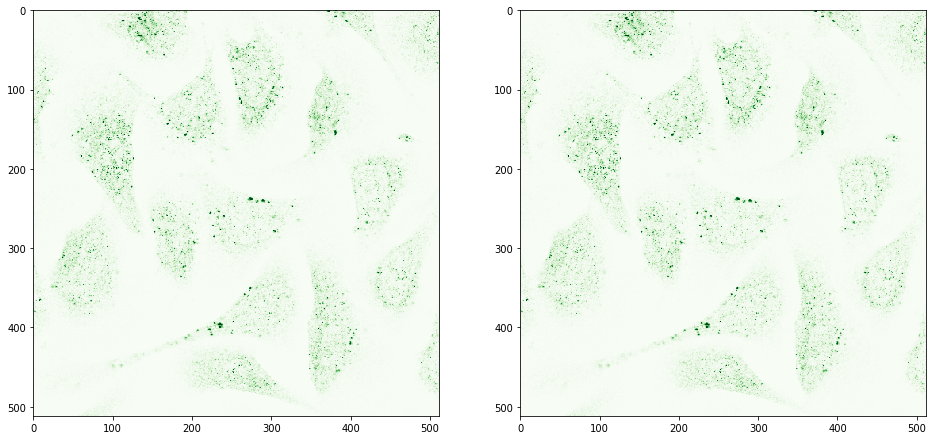

In [22]:
example = images[0, 0]
preprocessed = image_preprocessor.preprocess(example)
print(example.shape)
print(preprocessed.shape)

fig, ax = plt.subplots(1,2,figsize=(16,14))
ax[0].imshow(example, cmap="Greens")
ax[1].imshow(preprocessed.reshape(512, 512), cmap="Greens")

You can see that we have lost a lot of information by downscaling the image!

## Data generator

In [28]:
import keras 

class DataGenerator(keras.utils.Sequence):
    def __init__(self, list_ids, data, _model_parameters, _image_preprocessor, drop_list, shuffle=False,
                 use_cache=False):
        '''
        :params list_id      : list of image id  
        :params data         : train data with pandas format
        :_model_parameters   : parameters setting class
        :_image_preprocessor : image preprocessor class
        :drop_list           : the cols name to drop 
        :shuffle             : is shuffel data
        :use_cache           : use cache to improve compute performance 
        '''
        self.params = _model_parameters
        self.preprocessor = _image_preprocessor        
        self.data = data.copy() # each Id of the dataset
        self.data.set_index('Id', inplace=True)
        self.drop_list = drop_list
        self.remained_cols = [c for c in data.columns if c not in drop_list]        
        self.list_ids = list_ids
        self.dim =(self.params.scaled_row_dim, self.params.scaled_col_dim)
        self.batch_size = self.params.batch_size
        self.n_channels = self.params.n_channels
        self.n_classes = self.params.n_classes
        self.shuffle = shuffle        
        self.use_cache = use_cache
        if self.use_cache == True:
            self.cache = np.zeros((len(list_ids), 
                                   self.params.scaled_row_dim,
                                   self.params.scaled_col_dim,
                                   self.params.n_channels))
            self.is_cached = np.zeros((len(list_ids)))
        
        self.on_epoch_end()
        
    
    def on_epoch_end(self):
        # Updates indexes after each epoch
        self.indexes = np.arange(len(self.list_ids))
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def get_targets_per_image(self, identifier):
        return self.data.loc[identifier, self.remained_cols].values
        #return self.data.loc[self.data.Id == identifier].drop(self.drop_list, axis=1).values
    
    def __data_generation(self, _list_ids_temp, _indexes):
        # initialization
        X = np.zeros((self.batch_size, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size, self.n_classes), dtype=int)
        
        if self.use_cache == True:
            X = self.cache[_indexes]
            for i, identifier in enumerate(_list_ids_temp[np.where(self.is_cached[_indexes] == 0)]):
                image = self.preprocessor.load_image(identifier)
                image = self.preprocessor.preprocess(image)
                self.is_cached[indexes[i]] = 1
                self.cache[indexes[i]] = image
                X[i] = image
                y[i] = self.get_targets_per_image(identifier)
        else:
            for i, identifier in enumerate(_list_ids_temp):
                image = self.preprocessor.load_image(identifier)
                image = self.preprocessor.preprocess(image)
                X[i] = image
                y[i] = self.get_targets_per_image(identifier)
        return X, y 
    
    def __len__(self):
        "Denotes the number of batches per epoch"
        return int(np.floor(len(self.list_ids) / self.batch_size)) + 1
    
    def __getitem__(self, index):
        "Generate one batch of data"
        while index <= self.__len__():
            if index == self.__len__():
                indexes = self.indexes[index * self.batch_size: -1]        
            else:
                indexes = self.indexes[index * self.batch_size: (index + 1) * self.batch_size]        
            list_ids_temp = np.array([self.list_ids[k] for k in indexes])
            training_x, training_y = self.__data_generation(list_ids_temp, indexes)
            return training_x, training_y
    

In [29]:
drop_list = ["Id", "Target", "labels", "nb_labels"]
training_generator = DataGenerator(partition['training'][0:200], 
                                   train_data, model_parameters, image_preprocessor, drop_list)


In [24]:
%%time 
for i in range(8):
    im, lbl = training_generator[i]

CPU times: user 25.8 s, sys: 35.8 s, total: 1min 1s
Wall time: 41.3 s


In [392]:
# if sending all the data to use_cache module, it will cause memeory error
training_generator_cache = DataGenerator(partition['training'][0:200], 
                                         train_data, model_parameters, image_preprocessor, 
                                         drop_list, use_cache=True)


In [393]:
%%time 
for i in range(8):
    im, lbl = training_generator_cache[i]

CPU times: user 5.38 s, sys: 4.44 s, total: 9.82 s
Wall time: 3.27 s


In [30]:
from tqdm import tqdm
class PredictGenerator:
    def __init__(self, predict_ids, _image_preprocessor, predict_path):
        self.preprocessor = _image_preprocessor
        self.preprocessor.basepath = predict_path
        self.identifiers = predict_ids
        
    def predict(self, model):
        y = np.empty(shape=(len(self.identifiers), self.preprocessor.parameter.n_classes))
        for n in tqdm(range(len(self.identifiers))):
            image = self.preprocessor.load_image(self.identifiers[n])
            image = self.preprocessor.preprocess(image)
            image = image.reshape((1, *image.shape))
            y[n] = model.predict(image)
        return y
    

# Building model

In [36]:
from keras import models, layers
from keras import Model
from keras import losses, optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from keras import backend as K
from keras.utils import multi_gpu_model

In [27]:
class BaseLineModel:
    def __init__(self, _model_parameters):
        self.params = _model_parameters
        self.n_classes = self.params.n_classes
        self.img_rows = self.params.scaled_row_dim
        self.img_cols = self.params.scaled_col_dim
        self.n_channels = self.params.n_channels
        self.input_shape = (self.img_rows, self.img_cols, self.n_channels)
        self.my_metrics = ['accuracy']
        

    def build_model(self):        
        img_input = layers.Input(self.input_shape, name='Img_input')
        x = layers.Conv2D(16, (3, 3), activation='relu')(img_input)
        x = layers.Conv2D(32, (3, 3), activation='relu')(x)
        x = layers.MaxPooling2D(pool_size=(2, 2))(x)
        x = layers.Dropout(0.25)(x)
        x = layers.Flatten()(x)
        x = layers.Dense(64, activation='relu')(x)
        x = layers.Dropout(0.5)(x)
        x = layers.Dense(self.n_classes, activation='sigmoid')(x)
        model = Model(img_input, x, name='baseline')
        return model
        
        
baseline = BaseLineModel(model_parameters)
model = baseline.build_model()


In [28]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Img_input (InputLayer)       (None, 512, 512, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 510, 510, 16)      448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 508, 508, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 254, 254, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 254, 254, 32)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2064512)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                132128832 
__________

# Define loss function

In [29]:
from keras.losses import binary_crossentropy
from keras import backend as K
import tensorflow as tf

def f1(y_true, y_pred, threshold=0.1):
    #y_pred = K.round(y_pred) # threshold = 0.5
    #keras_placeholder = K.placeholder(shape=(None, 28))
    #y_pred = K.cast(K.greater(K.clip(keras_placeholder, 0.0, 1.0), 
    #                          threshold), K.floatx())
    y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), threshold), K.floatx())
    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true) * (1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true) * y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true * (1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred, threshold=0.1):
    #y_pred = K.round(y_pred) # threshold = 0.5
    #keras_placeholder = K.placeholder(shape=(None, 28))
    #y_pred = K.cast(K.greater(K.clip(keras_placeholder, 0.0, 1.0), 
    #                          threshold), K.floatx())
    y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), threshold), K.floatx())
    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true) * (1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true) * y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true * (1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2 * p * r / (p + r + K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

def f1_min(y_true, y_pred):
    f1 = base_f1(y_true, y_pred)
    return K.min(f1)

def f1_max(y_true, y_pred):
    f1 = base_f1(y_true, y_pred)
    return K.max(f1)

def f1_mean(y_true, y_pred):
    f1 = base_f1(y_true, y_pred)
    return K.mean(f1)

def f1_std(y_true, y_pred):
    f1 = base_f1(y_true, y_pred)
    return K.std(f1)

# Define callback function

In [30]:
from keras.optimizers import Adadelta
weight_path = "{}_weights.best.hdf5".format('model')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min',
                             save_weights_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.5, 
                              patience=3, 
                              verbose=1, 
                              min_delta=0.0001,
                              mode='min', 
                              cooldown=2, 
                              min_lr=1e-6)

early_stopping = EarlyStopping(monitor='val_loss', 
                               mode='min', 
                               patience=15)

callbacks_list = [checkpoint, early_stopping, reduce_lr]

# Training model

In [31]:
from keras.utils import multi_gpu_model
isMultiGPU = 1
if isMultiGPU:
    parallel_model = multi_gpu_model(model, 2)
    parallel_model.compile(optimizer=optimizers.Adam(1e-4, decay=1e-6), 
                           loss='binary_crossentropy',
                           metrics=[f1, 'binary_accuracy'])
else:
    model.compile(optimizer=optimizers.Adam(1e-4, decay=1e-6), 
                  loss='binary_crossentropy',
                  metrics=[f1, 'binary_accuracy'])

In [32]:
%%time
MAX_TRAIN_SETPS = 5
drop_list = ["Id", "Target", "labels", "nb_labels"]
kfold_evaluation = []
for i, partition in enumerate(partitions[0:1]):
    print('=== Training Fold: {} ==='.format(i))
    drop_list = ["Id", "Target", "labels", "nb_labels"]
    training_generator = DataGenerator(partition['training'], train_data, model_parameters, image_preprocessor, drop_list)
    validation_generator = DataGenerator(partition['validation'], train_data, model_parameters, image_preprocessor, drop_list)
    #step_count = min(MAX_TRAIN_SETPS, len(partition["training"]) // model_parameters.batch_size)
    if isMultiGPU:
        loss_history = [parallel_model.fit_generator(generator=training_generator, 
                                                     #steps_per_epoch=step_count,
                                                     epochs=model_parameters.n_epochs,
                                                     validation_data=validation_generator,
                                                     callbacks=callbacks_list,
                                                     use_multiprocessing=False,
                                                     shuffle=True,
                                                     workers=8)]   
    else:
        loss_history = [model.fit_generator(generator=training_generator, 
                                            #steps_per_epoch=step_count,
                                            epochs=model_parameters.n_epochs,
                                            validation_data=validation_generator,
                                            callbacks=callbacks_list,
                                            use_multiprocessing=False,
                                            shuffle=True,
                                            workers=8)]    
    eval_history = parallel_model.evaluate_generator(generator=validation_generator,
                                                     use_multiprocessing=True, 
                                                    workers=2)    
    kfold_evaluation.append(eval_history)
    

=== Training Fold: 0 ===
Epoch 1/1
648/648 [==============================] - 1020s 2s/step - loss: 0.7777 - f1: 0.0954 - binary_accuracy: 0.7536 - val_loss: 0.4106 - val_f1: 0.0976 - val_binary_accuracy: 0.9337

Epoch 00001: val_loss improved from inf to 0.41064, saving model to model_weights.best.hdf5
CPU times: user 1h 21s, sys: 43min 16s, total: 1h 43min 38s
Wall time: 26min 41s


In [36]:
loss_history[0].history

{'binary_accuracy': [0.7536461765383496],
 'f1': [0.09540634774487972],
 'loss': [0.7776901965707909],
 'lr': [1e-04],
 'val_binary_accuracy': [0.9336523038369638],
 'val_f1': [0.09760713979693843],
 'val_loss': [0.41063851798758094]}

In [34]:
eval_history

[0.3898385394318604, 0.09738845842671984, 0.9331528224326946]

# Training evaluation

In [ ]:
epich = np.cumsum(np.concatenate([np.linspace(0.5, 1, len(mh.epoch)) for mh in loss_history]))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(22, 10))
_ = ax1.plot(epich,
             np.concatenate([mh.history['loss'] for mh in loss_history]),
             'b-',
             epich, np.concatenate([mh.history['val_loss'] for mh in loss_history]), 
             'r-')
ax1.legend(['Training', 'Validation'])
ax1.set_title('Loss')

_ = ax2.plot(epich, np.concatenate([mh.history['dice_loss'] for mh in loss_history]), 
             'b-', epich, 
             np.concatenate([mh.history['val_dice_loss'] for mh in loss_history]),
             'r-')
ax2.legend(['Training', 'Validation'])
ax2.set_title('Dice Loss')

_ = ax3.plot(epich, np.concatenate([mh.history['binary_accuracy'] for mh in loss_history]),
             'b-', epich, 
             np.concatenate([mh.history['val_binary_accuracy'] for mh in loss_history]),
             'r-')
ax3.legend(['Training', 'Validation'])
ax3.set_title('Binary Accuracy (%)')
    
_ = ax4.plot(epich, np.concatenate([mh.history['dice_coef'] for mh in loss_history]), 
             'b-', epich, 
             np.concatenate([mh.history['val_dice_coef'] for mh in loss_history]),
             'r-')
ax4.legend(['Training', 'Validation'])
ax4.set_title('Dice Coef')


In [65]:
%%time
test_image_preprocessor = ImagePreprocessor(model_parameters, use_aug=False, is_training=False)
predict_generator = PredictGenerator(partition['validation'], test_image_preprocessor, train_image_path)
proba_predictions = predict_generator.predict(parallel_model)
baseline_proba_predictions = pd.DataFrame(proba_predictions, 
                                          columns = train_data.drop(drop_list, axis=1).columns)


CPU times: user 26min 24s, sys: 30min 57s, total: 57min 22s
Wall time: 24min 47s


In [66]:
baseline_proba_predictions.head()

,Nucleoplasm,Nuclear membrane,Nucleoli,Nucleoli fibrillar center,Nuclear speckles,Nuclear bodies,Endoplasmic reticulum,Golgi apparatus,Peroxisomes,Endosomes,...,Microtubule organizing center,Centrosome,Lipid droplets,Plasma membrane,Cell junctions,Mitochondria,Aggresome,Cytosol,Cytoplasmic bodies,Rods & rings
0,0.433123,0.043956,0.127890,0.052441,0.065088,0.090678,0.034151,0.103657,0.000893,0.000866,...,0.030275,0.049543,0.003181,0.136797,0.023552,0.105660,0.007043,0.276642,0.008152,0.000340
1,0.431678,0.037214,0.116789,0.044711,0.056420,0.081360,0.028589,0.093816,0.000576,0.000567,...,0.025113,0.042171,0.002271,0.125897,0.018993,0.095359,0.005178,0.266305,0.006144,0.000206
2,0.430947,0.037684,0.117565,0.045409,0.056956,0.081677,0.028793,0.094306,0.000596,0.000579,...,0.025402,0.042672,0.002305,0.126547,0.019217,0.095891,0.005290,0.267195,0.006273,0.000214
3,0.432275,0.041472,0.123473,0.049482,0.061612,0.086873,0.031862,0.099957,0.000750,0.000733,...,0.028286,0.046548,0.002810,0.132594,0.021642,0.101534,0.006241,0.272746,0.007354,0.000284
4,0.429534,0.035408,0.113749,0.042946,0.054002,0.078199,0.026801,0.090619,0.000501,0.000489,...,0.023612,0.040200,0.002011,0.122693,0.017735,0.092296,0.004727,0.263744,0.005637,0.000178


Text(0,0.5,'Percentage')

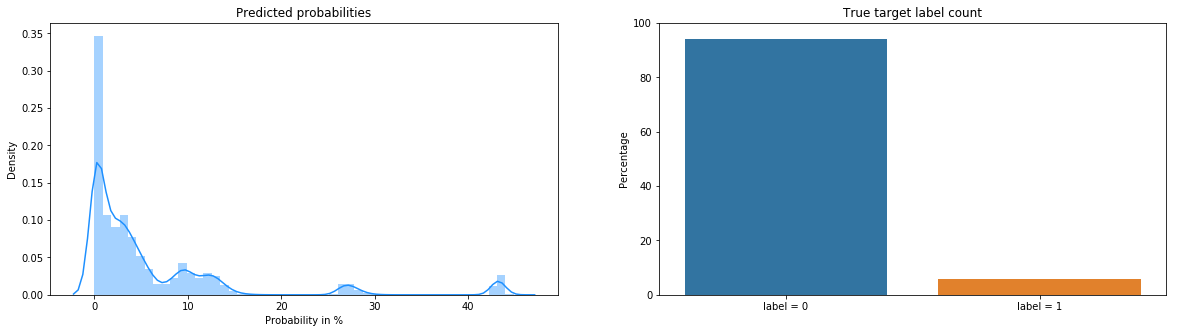

In [67]:
validation_labels = train_data.loc[train_data.Id.isin(partition["validation"])]

hot_values = validation_labels.drop(drop_list, axis=1).values.flatten()
one_hot = (hot_values.sum()) / hot_values.shape[0] * 100
zero_hot = (hot_values.shape[0] - hot_values.sum()) / hot_values.shape[0] * 100

fig, ax = plt.subplots(1,2, figsize=(20,5))
sns.distplot(proba_predictions.flatten() * 100, color="DodgerBlue", ax=ax[0])
ax[0].set_xlabel("Probability in %")
ax[0].set_ylabel("Density")
ax[0].set_title("Predicted probabilities")
sns.barplot(x=["label = 0", "label = 1"], y=[zero_hot, one_hot], ax=ax[1])
ax[1].set_ylim([0,100])
ax[1].set_title("True target label count")
ax[1].set_ylabel("Percentage")

Text(0.5,1,'Percentage of hot counts (ones) per target class')

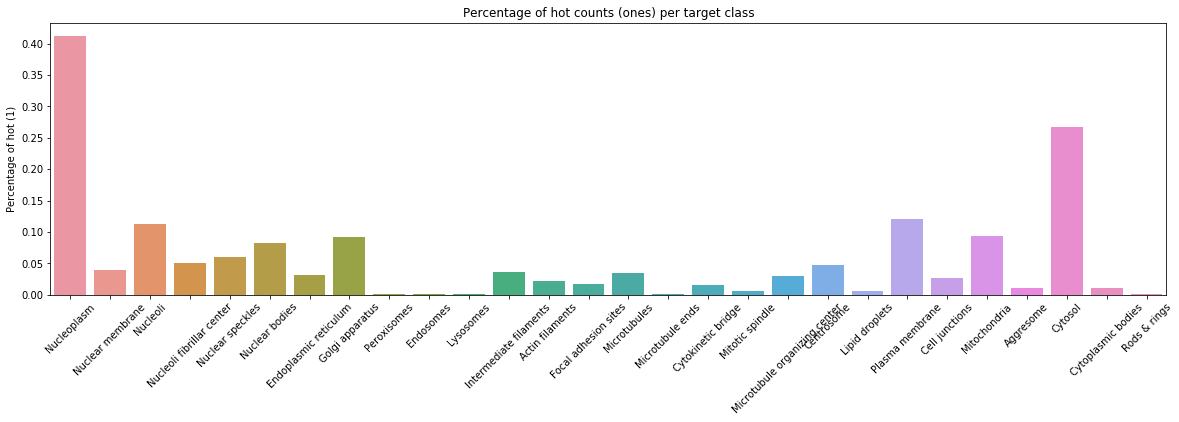

In [69]:
# validation data 中每個 class 的在 overall 中的比例
mean_targets = validation_labels.drop(drop_list, axis=1).mean()
labels = validation_labels.drop(drop_list, axis=1).columns.values
fig, ax = plt.subplots(1,1,figsize=(20,5))
sns.barplot(x=labels, y=mean_targets.values, ax=ax)
ax.set_xticklabels(labels=labels, rotation=45)
ax.set_ylabel("Percentage of hot (1)")
ax.set_title("Percentage of hot counts (ones) per target class")

Text(0.5,1,'Standard deviation of predicted probability per class over all samples')

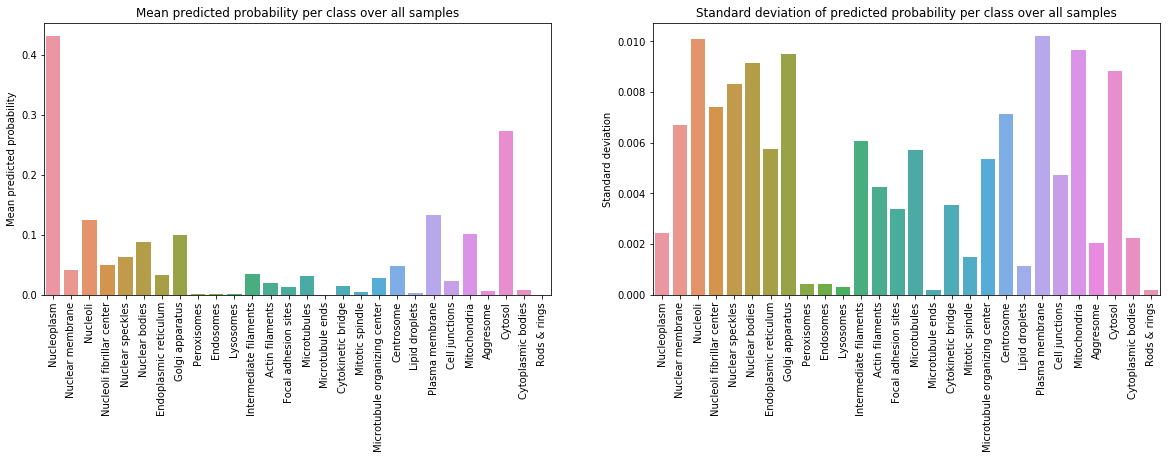

In [68]:
mean_predictions = np.mean(proba_predictions, axis=0)
std_predictions = np.std(proba_predictions, axis=0)

fig, ax = plt.subplots(1, 2, figsize=(20, 5))
sns.barplot(x=labels, y=mean_predictions, ax=ax[0])
ax[0].set_xticklabels(labels=labels, rotation=90)
ax[0].set_ylabel("Mean predicted probability")
ax[0].set_title("Mean predicted probability per class over all samples")

sns.barplot(x=labels, y=std_predictions, ax=ax[1])
ax[1].set_xticklabels(labels=labels, rotation=90)
ax[1].set_ylabel("Standard deviation")
ax[1].set_title("Standard deviation of predicted probability per class over all samples")

* Our baseline model seemed to learn something even if this something does not look very nice.
* Taking a look at the standard deviation we can see that all samples have nearly the same predicted values. There is no deviation, no difference between them. This is of course very bad! :-(

(0, 1)

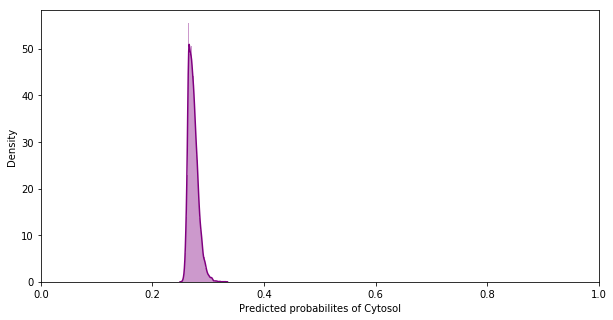

In [70]:
feature = 'Cytosol'
plt.figure(figsize=(10,5))
sns.distplot(baseline_proba_predictions[feature].values[0:-1], color="Purple")
plt.xlabel("Predicted probabilites of {}".format(feature))
plt.ylabel("Density")
plt.xlim([0,1])

# Prediction 

In [ ]:
#seg_model.load_weights(weight_path)
#seg_model.save('seg_model.h5')

In [73]:
sample_submission = pd.read_csv(str(data_folder / 'sample_submission.csv'))

In [90]:
%%time
test_image_preprocessor = ImagePreprocessor(model_parameters, use_aug=False, is_training=False)
predict_generator = PredictGenerator(sample_submission.Id.values[0:10], test_image_preprocessor, test_image_path)
proba_predictions = predict_generator.predict(parallel_model)

CPU times: user 1.68 s, sys: 1.67 s, total: 3.35 s
Wall time: 1.46 s


In [75]:
model_arch = 'baseline'
threshold_list = [0.2, 0.35]
for t in threshold_list:
    submission_df = np.where(proba_predictions > threshold, 1, 0)
    final_submission = []
    for s in range(len(sample_submission.Id.values)):
        predict_labels = ''
        for i in list(np.where(submission_df[s] == 1)[0]):
            predict_labels += str(i) + ' '
        
        final_submission.append(predict_labels.strip())
    sample_submission['Predicted'] = final_submission
    sample_submission.to_csv('{}_{}.csv'.format(model_arch, str(threshold_list).replace('.', '')), 
                             index=False)
    